# Parkinson disease predicition with Modified Grey Wolf Optimization (MGWO) using Handpd dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import math
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

Load the respective Parkinson dataset

In [2]:
my_data=pd.read_table('NewMeander.csv',sep=",")
#my_data=pd.read_table('NewSpiral.csv',sep=",")
my_data.head()


,_ID_EXAM,IMAGE_NAME,ID_PATIENT,CLASS_TYPE,GENDER,RIGH_LEFT_HANDED,AGE,RMS,MAX_BETWEEN_ET_HT,MIN_BETWEEN_ET_HT,STD_DEVIATION_ET_HT,MRT,MAX_HT,MIN_HT,STD_HT,CHANGES_FROM_NEGATIVE_TO_POSITIVE_BETWEEN_ET_HT
0,H1,mea1-H1.jpg,59,1,M,R,58,7434.180108,10120.222430,42913.38070,0.071112,48.761320,203.049894,0.119590,2236.376294,0.114428
1,H2,mea1-H2.jpg,76,1,M,R,60,10132.444470,11923.713750,64317.66969,0.581945,31.231012,212.489845,0.029351,1658.672664,0.064394
2,H3,mea1-H3.jpg,301,1,F,R,56,5320.969169,8443.270014,39979.95076,0.000388,54.281633,227.843584,0.757457,3148.250320,0.158879
3,H4,mea1-H4.jpg,102,1,M,R,24,8659.652924,13558.029200,69319.27081,0.008113,52.104352,185.538482,0.220402,2606.647576,0.127358
4,H5,mea1-H5.jpg,305,1,M,R,79,7293.018199,7531.636413,34595.02260,0.102315,40.991308,198.680893,0.071312,3193.983137,0.155660


In [3]:
df = my_data.pop('CLASS_TYPE') # remove column status and store it in df
my_data['CLASS_TYPE']=df # add status as a 'new' column.
my_data.drop(columns=["_ID_EXAM","IMAGE_NAME","ID_PATIENT"],inplace=True)
gender = {'M': 1,'F': 0}
my_data.GENDER = [gender[item] for item in my_data.GENDER]
hand = {'R': 1,'L': 0}
my_data.RIGH_LEFT_HANDED = [hand[item] for item in my_data.RIGH_LEFT_HANDED]
my_data.head()


,GENDER,RIGH_LEFT_HANDED,AGE,RMS,MAX_BETWEEN_ET_HT,MIN_BETWEEN_ET_HT,STD_DEVIATION_ET_HT,MRT,MAX_HT,MIN_HT,STD_HT,CHANGES_FROM_NEGATIVE_TO_POSITIVE_BETWEEN_ET_HT,CLASS_TYPE
0,1,1,58,7434.180108,10120.222430,42913.38070,0.071112,48.761320,203.049894,0.119590,2236.376294,0.114428,1
1,1,1,60,10132.444470,11923.713750,64317.66969,0.581945,31.231012,212.489845,0.029351,1658.672664,0.064394,1
2,0,1,56,5320.969169,8443.270014,39979.95076,0.000388,54.281633,227.843584,0.757457,3148.250320,0.158879,1
3,1,1,24,8659.652924,13558.029200,69319.27081,0.008113,52.104352,185.538482,0.220402,2606.647576,0.127358,1
4,1,1,79,7293.018199,7531.636413,34595.02260,0.102315,40.991308,198.680893,0.071312,3193.983137,0.155660,1


In [4]:
X = my_data.iloc[0:my_data.shape[0],0:my_data.shape[1]-1].values
y = my_data.iloc[0:my_data.shape[0],my_data.shape[1]-1:my_data.shape[1]].values
dim=X.shape[1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


Feature scaling is a method used to normalize the range of features of data

In [6]:
# Feature Scaling
def featureScaling(X_train,X_test):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train,X_test
    
X_train,X_test=featureScaling(X_train,X_test)


Initialize alpha_pos, beta_pos, delta_pos with an array
of size (1 * dimension_size) containing all zero.

In [7]:
alpha_pos=np.zeros(dim)
beta_pos=np.zeros(dim)
delta_pos=np.zeros(dim)

Initialize the variables alpha_score, beta_score and
delta_score with zero

In [8]:
alpha_score=0
beta_score=0 
delta_score=0

 Initialize the population of the wolves with random
values of size (no_of_search_agents * dimension_size)
and store it into the array Positions.

In [9]:
SearchAgents_no=10
lb=0
ub=1
lb = [lb] * dim
ub = [ub] * dim
Positions = np.zeros((SearchAgents_no, dim))
for i in range(dim):
    Positions[:, i] = (np.random.uniform(0, 1, SearchAgents_no) * (ub[i] - lb[i]) + lb[i])


Calculate the importance (imp) of each features using model.feature_importances_

In [10]:
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d : Score: %.5f' % (i,v), end="  ")


Feature: 0 : Score: 0.00881  Feature: 1 : Score: 0.00805  Feature: 2 : Score: 0.18217  Feature: 3 : Score: 0.07640  Feature: 4 : Score: 0.06607  Feature: 5 : Score: 0.08682  Feature: 6 : Score: 0.04106  Feature: 7 : Score: 0.22331  Feature: 8 : Score: 0.05263  Feature: 9 : Score: 0.09231  Feature: 10 : Score: 0.10588  Feature: 11 : Score: 0.05650  

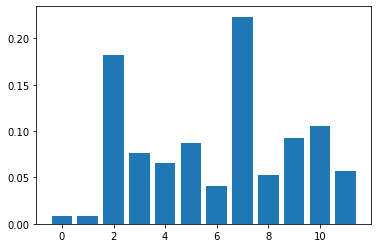

In [11]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Define the fitness function (fit) returning the fitness of
each search agents

In [12]:
def fitness_function(pos):
    lf=len([i for i in pos if i > 0.5]) 
    imp=0
    for i in [index for index,value in enumerate(pos) if value > 0.5]:
        imp+=importance[i]
    
    lt=dim
    wf=0.7
    fnt=imp +(wf*(1-(lf/lt)))
    return fnt
    

In [13]:
Max_iter=1000
for l in range(0, Max_iter):
    for i in range(0, SearchAgents_no):

        # Return back the search agents that go beyond the boundaries of the search space
        for j in range(dim):
            Positions[i, j] = np.clip(Positions[i, j], lb[j], ub[j])
        
        # Calculate objective function for each search agent
        fitness = fitness_function(Positions[i, :])
        
        
        if fitness > alpha_score :
            alpha_score = fitness
            alpha_pos = np.array(Positions[i,:])
        if (fitness < alpha_score and fitness > beta_score):
            beta_score = fitness
            beta_pos = np.array(Positions[i,:])
        if (fitness < alpha_score and fitness < beta_score and fitness > delta_score):
            delta_score = fitness
            delta_pos = np.array(Positions[i,:])
   
    #a = 2 - l * ((2) / Max_iter) # a decreases linearly fron 2 to 0
    a = 2 - 2 * ((l / Max_iter)**2)
    
    # Update the Position of search agents including omegas
    for i in range(0, SearchAgents_no):
        for j in range(0, dim):

            r1 = random.random()  # r1 is a random number in [0,1]
            r2 = random.random()  # r2 is a random number in [0,1]

            A1 = 2 * a * r1 - a
            if abs(A1)>1:
                    A1=2*2*r1-2
            C1 = 2 * r2
               
            D_alpha = abs(C1 * alpha_pos[j] - Positions[i, j])
            X1 = alpha_pos[j] - A1 * D_alpha    

            r1 = random.random()
            r2 = random.random()

            A2 = 2 * a * r1 - a
            if abs(A2)>1:
                    A2=2*2*r1-2
            C2 = 2 * r2
    
            D_beta = abs(C2 * beta_pos[j] - Positions[i, j])
            X2 = beta_pos[j] - A2 * D_beta         

            r1 = random.random()
            r2 = random.random()

            A3 = 2 * a * r1 - a
            if abs(A3)>1:
                    A3=2*2*r1-2
            C3 = 2 * r2
             
            D_delta = abs(C3 * delta_pos[j] - Positions[i, j])
            X3 = delta_pos[j] - A3 * D_delta
              
            x=(X1 + X2 + X3)/3
            
            sig_x = 1/(1 + math.exp(10 *(x-0.5)))
    
            Positions[i, j]=sig_x



Use the Alpha_pos for feature selection

In [14]:
def dimReduction(X_train,X_test,alpha_pos):
    X_train=np.delete(X_train,[index for index,value in enumerate(alpha_pos) if value < 0.5], axis = 1) 
    X_test=np.delete(X_test,[index for index,value in enumerate(alpha_pos) if value < 0.5], axis = 1)
    return X_train,X_test
X_train,X_test=dimReduction(X_train,X_test,alpha_pos)

A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and we create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.

In [15]:
estimator = [] 
estimator.append(('RFC', RandomForestClassifier())) 
estimator.append(('KNN',KNeighborsClassifier()))
estimator.append(('DTC', DecisionTreeClassifier()))

# Voting Classifier with hard voting 
vot_hard = VotingClassifier(estimators = estimator, voting ='hard') 
vot_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('RFC',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators='warn',
                                                     n_jobs=None,
      

In [16]:
 
def prediction(X_test):
    return vot_hard.predict(X_test) 
    
y_pred=prediction(X_test)

In [17]:
# using accuracy_score metric to predict accuracy 
print(accuracy_score(y_test, y_pred))

0.8375


In binary classification, the count of true negatives is C(0,0), false negatives is C(1,0),true positives is C(1,1) and false positives C(0,1)is.

In [18]:
print(confusion_matrix(y_test,y_pred))


[[30  8]
 [ 5 37]]


Precision = TruePositives / (TruePositives + FalsePositives)



Recall = TruePositives / (TruePositives + FalseNegatives)


F1-score = 2 x Recall x Precision / Recall+Precision

In [19]:
print(classification_report(y_test,y_pred,target_names=["No Parkinson","Yes Parkinson"]))

               precision    recall  f1-score   support

 No Parkinson       0.86      0.79      0.82        38
Yes Parkinson       0.82      0.88      0.85        42

     accuracy                           0.84        80
    macro avg       0.84      0.84      0.84        80
 weighted avg       0.84      0.84      0.84        80

